In [2]:
# Standard libraries
import sys
# Add your custom path
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)
import os
import logging
import argparse # Argument parsing

# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import torch
import torch.optim as optim
import copy                    # clone tensor
import time

# Custom imports


from GEMS_TCO import kernels_reparam_space_time_gpu as kernels_reparam_space_time
from GEMS_TCO import orderings as _orderings 
from GEMS_TCO import alg_optimization, BaseLogger

from typing import Optional, List, Tuple
from pathlib import Path
import typer
import json
from json import JSONEncoder
from GEMS_TCO import configuration as config
from GEMS_TCO.data_loader import load_data2, exact_location_filter
from GEMS_TCO import debiased_whittle
from torch.nn import Parameter

In [6]:
space: List[str] = ['1', '1']
lat_lon_resolution = [int(s) for s in space]
mm_cond_number: int = 8
years = ['2024']
#years = ['2025']
month_range = [7] 

output_path = input_path = Path(config.mac_estimates_day_path)
data_load_instance = load_data2(config.mac_data_load_path)

#lat_range_input = [1, 3]
#lon_range_input = [125.0, 129.0]

#lat_range_input=[0,5]      
#lon_range_input=[123, 133.0] 

lat_range_input=[-3,2]      
lon_range_input=[121, 131] 


df_map, ord_mm, nns_map = data_load_instance.load_maxmin_ordered_data_bymonthyear(
lat_lon_resolution=lat_lon_resolution, 
mm_cond_number=mm_cond_number,
years_=years, 
months_=month_range,

lat_range=lat_range_input,   
lon_range=lon_range_input

)

In [7]:
daily_aggregated_tensors_dw = [] 
daily_hourly_maps_dw = []      

daily_aggregated_tensors_vecc = [] 
daily_hourly_maps_vecc = []   


for day_index in range(31):
    hour_start_index = day_index * 8
    
    hour_end_index = (day_index + 1) * 8
    #hour_end_index = day_index*8 + 1
    hour_indices = [hour_start_index, hour_end_index]

    day_hourly_map, day_aggregated_tensor = data_load_instance.load_working_data(
    df_map, 
    hour_indices, 
    ord_mm= None,  # or just omit it
    dtype=torch.float64, # or just omit it 
    keep_ori=True  #keep_exact_loc
    )

    daily_aggregated_tensors_dw.append( day_aggregated_tensor )
    daily_hourly_maps_dw.append( day_hourly_map )



In [11]:
day = 1 

hour = 1
keys = list(daily_hourly_maps_dw[day].keys())
# 1. Get the specific tensor data
daily_hourly_maps_dw[day][keys[hour]][:200]



tensor([[1.9993e+00, 1.3099e+02, 2.4454e+02, 8.8060e+03],
        [1.9992e+00, 1.3093e+02, 2.4409e+02, 8.8060e+03],
        [1.9993e+00, 1.3087e+02, 2.4678e+02, 8.8060e+03],
        [1.9994e+00, 1.3081e+02, 2.4466e+02, 8.8060e+03],
        [1.9996e+00, 1.3074e+02, 2.4584e+02, 8.8060e+03],
        [1.9997e+00, 1.3068e+02, 2.4760e+02, 8.8060e+03],
        [1.9998e+00, 1.3062e+02, 2.4783e+02, 8.8060e+03],
        [1.9783e+00, 1.3056e+02, 2.4688e+02, 8.8060e+03],
        [1.9785e+00, 1.3049e+02, 2.4646e+02, 8.8060e+03],
        [1.9787e+00, 1.3043e+02, 2.4605e+02, 8.8060e+03],
        [1.9790e+00, 1.3037e+02, 2.4679e+02, 8.8060e+03],
        [1.9793e+00, 1.3031e+02, 2.4719e+02, 8.8060e+03],
        [1.9795e+00, 1.3024e+02, 2.4694e+02, 8.8060e+03],
        [1.9797e+00, 1.3018e+02, 2.4792e+02, 8.8060e+03],
        [1.9798e+00, 1.3012e+02, 2.4856e+02, 8.8060e+03],
        [1.9799e+00, 1.3006e+02, 2.4783e+02, 8.8060e+03],
        [1.9799e+00, 1.3000e+02, 2.4728e+02, 8.8060e+03],
        [1.979

start below

--- Analysis for first 3 days ---


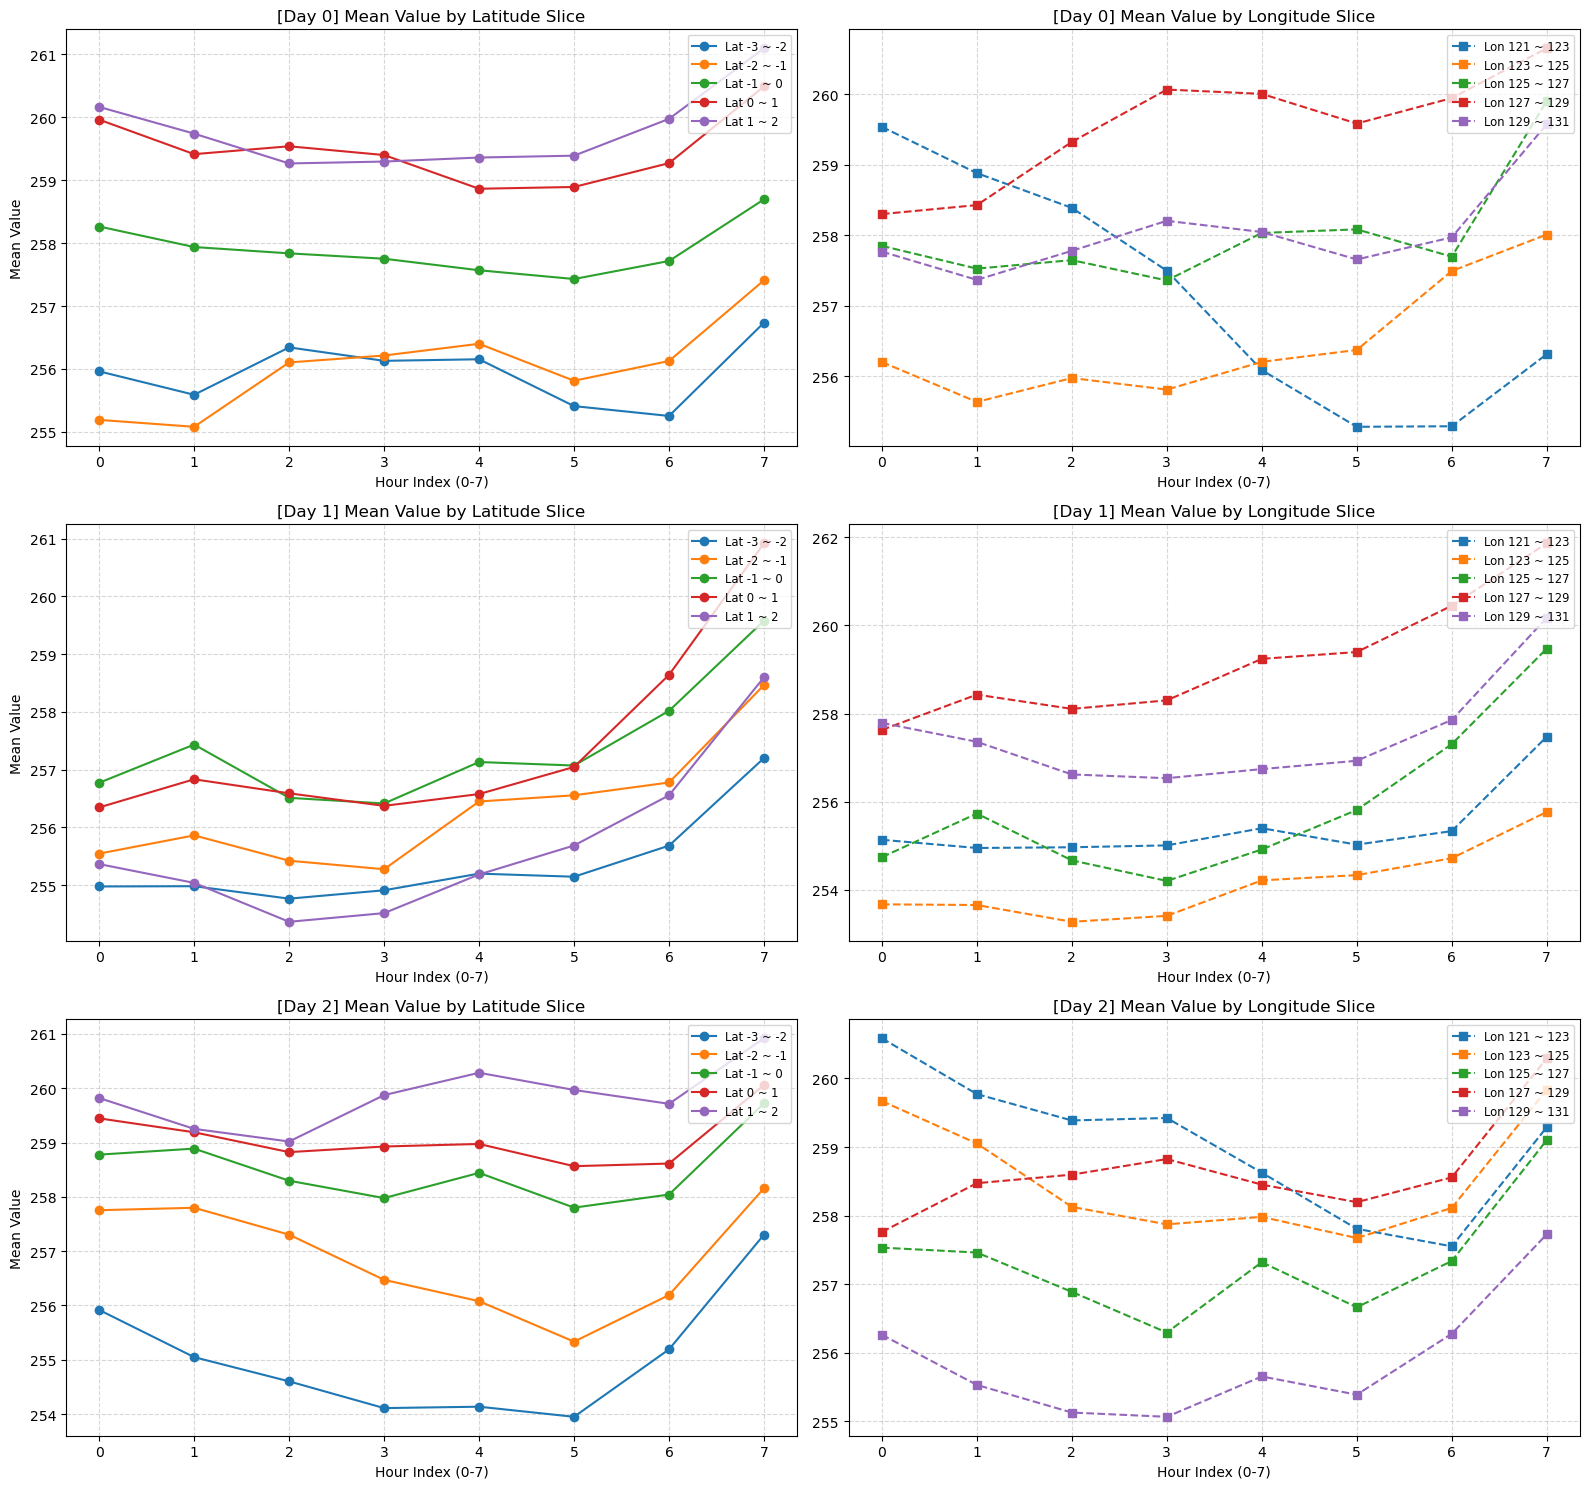

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def analyze_and_plot_slices(data_maps, days_to_check=3):
    # 3행 2열 그래프 생성 (행: 날짜, 열: Lat분석 / Lon분석)
    fig, axes = plt.subplots(days_to_check, 2, figsize=(16, 5 * days_to_check))
    
    # 1. Slice 구간 정의
    # Latitude: -3 to 2 (간격 1) -> 5개 구간: [-3, -2), [-2, -1), ...
    lat_bins = np.array([-3, -2, -1, 0, 1, 2])
    
    # Longitude: 121 to 131 (간격 2) -> 5개 구간: [121, 123), ...
    lon_bins = np.array([121, 123, 125, 127, 129, 131])
    
    # X축: 시간 인덱스 (0~7)
    hours_x = np.arange(8)

    print(f"--- Analysis for first {days_to_check} days ---")

    for day_idx in range(days_to_check):
        day_data = data_maps[day_idx]
        
        # [Key Sorting] 
        # 키가 정수(0,1,2...)라면 그냥 sorted()로 충분하지만,
        # 만약 문자열이 섞여있거나 순서가 보장되지 않을 경우를 대비해 안전하게 정렬
        try:
            sorted_keys = sorted(day_data.keys(), key=lambda x: int(x) if isinstance(x, (int, str)) and str(x).isdigit() else x)
        except:
            sorted_keys = sorted(day_data.keys())
            
        # 평균값 저장할 배열 (5개 슬라이스 x 8시간)
        # 초기값을 nan으로 채워 데이터가 없는 구간은 그래프가 끊기게 함
        lat_means = np.full((5, 8), np.nan)
        lon_means = np.full((5, 8), np.nan)
        
        for h_idx, key in enumerate(sorted_keys):
            if h_idx >= 8: break # 하루 8시간만 체크
            
            # 텐서 가져오기 및 numpy 변환
            tensor = day_data[key]
            if isinstance(tensor, torch.Tensor):
                data = tensor.detach().cpu().numpy() # detach 추가 (안전장치)
            else:
                data = tensor
            
            # Data Columns: [0:Lat, 1:Lon, 2:Value, 3:Time]
            lats = data[:, 0]
            lons = data[:, 1]
            vals = data[:, 2]
            
            # --- Latitude Slicing ---
            # np.digitize: 값이 bins[i-1] <= x < bins[i] 일 때 i 반환
            # 결과 인덱스: 1, 2, 3, 4, 5 -> (배열 인덱스 맞추기 위해 -1) -> 0, 1, 2, 3, 4
            lat_inds = np.digitize(lats, lat_bins) - 1
            for i in range(5):
                mask = lat_inds == i
                if np.any(mask):
                    lat_means[i, h_idx] = np.mean(vals[mask])
            
            # --- Longitude Slicing ---
            lon_inds = np.digitize(lons, lon_bins) - 1
            for i in range(5):
                mask = lon_inds == i
                if np.any(mask):
                    lon_means[i, h_idx] = np.mean(vals[mask])

        # --- 그래프 그리기 (Lat - Left Column) ---
        ax_lat = axes[day_idx, 0]
        for i in range(5):
            label = f"Lat {lat_bins[i]} ~ {lat_bins[i+1]}"
            # 데이터가 하나라도 있어야 그림
            if not np.all(np.isnan(lat_means[i])):
                ax_lat.plot(hours_x, lat_means[i], marker='o', label=label)
        
        ax_lat.set_title(f"[Day {day_idx}] Mean Value by Latitude Slice")
        ax_lat.set_xlabel("Hour Index (0-7)")
        ax_lat.set_ylabel("Mean Value")
        ax_lat.grid(True, linestyle='--', alpha=0.5)
        ax_lat.legend(fontsize='small', loc='upper right')

        # --- 그래프 그리기 (Lon - Right Column) ---
        ax_lon = axes[day_idx, 1]
        for i in range(5):
            label = f"Lon {lon_bins[i]} ~ {lon_bins[i+1]}"
            if not np.all(np.isnan(lon_means[i])):
                ax_lon.plot(hours_x, lon_means[i], marker='s', linestyle='--', label=label)
            
        ax_lon.set_title(f"[Day {day_idx}] Mean Value by Longitude Slice")
        ax_lon.set_xlabel("Hour Index (0-7)")
        ax_lon.grid(True, linestyle='--', alpha=0.5)
        ax_lon.legend(fontsize='small', loc='upper right')

    plt.tight_layout()
    plt.show()

# 실행
analyze_and_plot_slices(daily_hourly_maps_dw, days_to_check=3)

평행선(Parallel): 모든 위도/경도 슬라이스에서 값이 같이 오르고 같이 내린다면 -> Interaction 항 불필요 (단순 Time + Lat 효과).

교차/기울기 차이(Cross/Diverge): 위쪽 위도에서는 값이 오르는데 아래쪽에서는 내리거나, 변화 폭이 확연히 다르다면 -> Interaction 항(Lat*Time) 필수.

28일 평균

--- Processing Average Trend for first 28 days ---


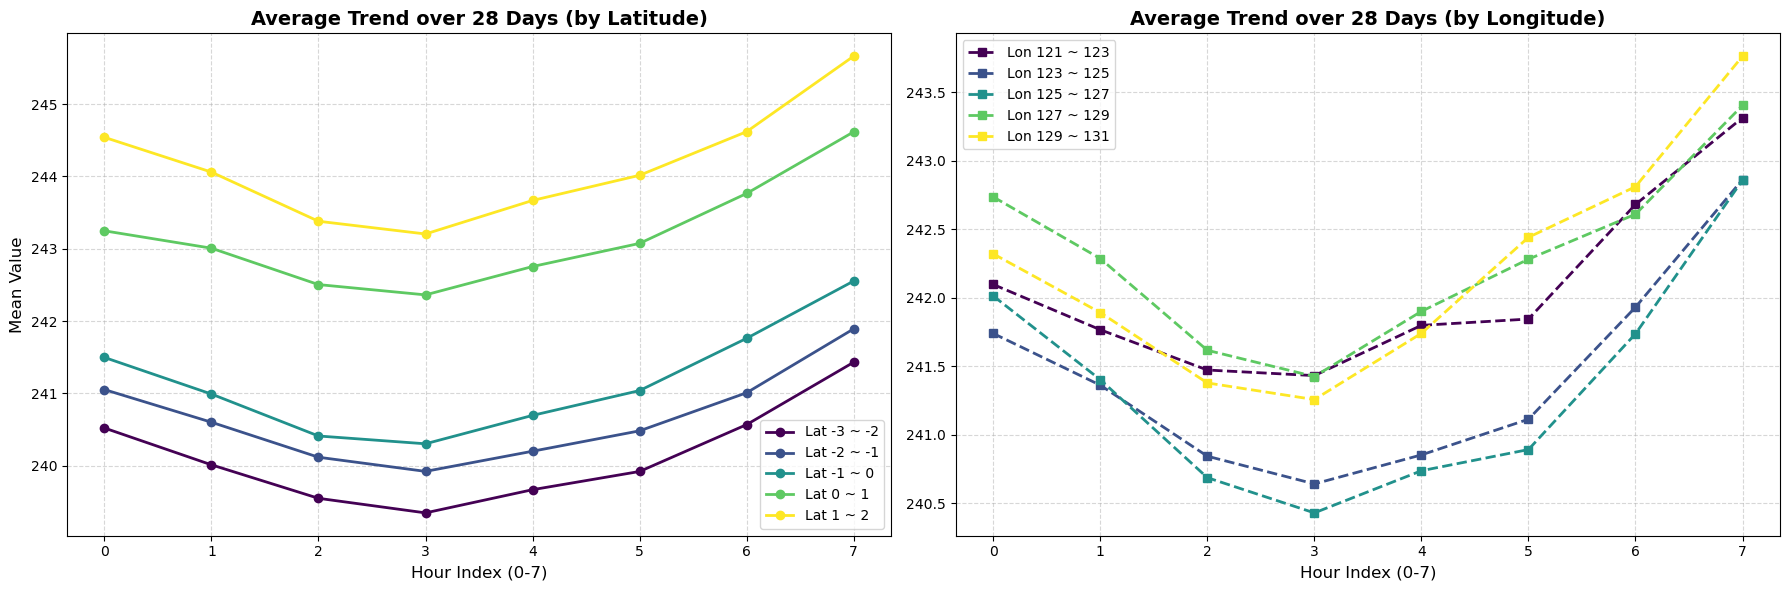

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def analyze_average_trend_28days(data_maps, days_to_average=28):
    """
    첫 28일(Day 0 ~ Day 27)의 데이터를 모두 취합하여,
    위도/경도 구간별 '평균적인 하루 패턴(Average Diurnal Cycle)'을 그립니다.
    """
    
    # 1. Slice 구간 정의 (기존과 동일)
    # Latitude: 5개 구간 (인덱스 0~4)
    lat_bins = np.array([-3, -2, -1, 0, 1, 2])
    # Longitude: 5개 구간 (인덱스 0~4)
    lon_bins = np.array([121, 123, 125, 127, 129, 131])
    
    hours_x = np.arange(8) # 0~7시
    
    # 2. 데이터 저장소 생성 (3D Array)
    # 구조: [Day(28), Slice(5), Hour(8)]
    # 초기값을 NaN으로 채워서 데이터가 없는 경우 평균 계산에서 제외되도록 함
    lat_daily_storage = np.full((days_to_average, 5, 8), np.nan)
    lon_daily_storage = np.full((days_to_average, 5, 8), np.nan)

    print(f"--- Processing Average Trend for first {days_to_average} days ---")

    # --- [Loop] 28일 데이터 순회 ---
    for day_idx in range(days_to_average):
        # 데이터가 혹시 리스트 범위를 벗어나거나 없으면 패스
        if day_idx >= len(data_maps) or data_maps[day_idx] is None:
            continue
            
        day_data = data_maps[day_idx]
        
        # 키 정렬 (안전 장치)
        try:
            sorted_keys = sorted(day_data.keys(), key=lambda x: int(x) if isinstance(x, (int, str)) and str(x).isdigit() else x)
        except:
            sorted_keys = sorted(day_data.keys())
            
        for h_idx, key in enumerate(sorted_keys):
            if h_idx >= 8: break # 8시간만
            
            # 텐서 추출 및 변환
            tensor = day_data[key]
            if isinstance(tensor, torch.Tensor):
                data = tensor.detach().cpu().numpy()
            else:
                data = tensor
            
            # 데이터가 비어있으면 스킵
            if data.size == 0:
                continue

            lats = data[:, 0]
            lons = data[:, 1]
            vals = data[:, 2]
            
            # --- Latitude Slicing & Mean ---
            # np.digitize: bins[i-1] <= x < bins[i]
            lat_inds = np.digitize(lats, lat_bins) - 1
            for i in range(5):
                mask = lat_inds == i
                if np.any(mask):
                    # [Day, Slice, Hour] 위치에 저장
                    lat_daily_storage[day_idx, i, h_idx] = np.mean(vals[mask])
            
            # --- Longitude Slicing & Mean ---
            lon_inds = np.digitize(lons, lon_bins) - 1
            for i in range(5):
                mask = lon_inds == i
                if np.any(mask):
                    lon_daily_storage[day_idx, i, h_idx] = np.mean(vals[mask])

    # 3. 28일치 평균 계산 (Aggregation)
    # axis=0 (Day 축)을 기준으로 평균 -> 결과 shape: (5, 8)
    # nanmean을 사용하여 NaN이 있는 날짜는 무시하고 평균 계산
    final_lat_means = np.nanmean(lat_daily_storage, axis=0)
    final_lon_means = np.nanmean(lon_daily_storage, axis=0)

    # 4. 그래프 그리기 (1행 2열)
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # --- Latitude Plot ---
    ax_lat = axes[0]
    # 컬러맵 설정 (구간별 색상 구분)
    colors = plt.cm.viridis(np.linspace(0, 1, 5))
    
    for i in range(5):
        label = f"Lat {lat_bins[i]} ~ {lat_bins[i+1]}"
        # 데이터가 하나라도 있으면 그리기
        if not np.all(np.isnan(final_lat_means[i])):
            ax_lat.plot(hours_x, final_lat_means[i], marker='o', linewidth=2, label=label, color=colors[i])

    ax_lat.set_title(f"Average Trend over {days_to_average} Days (by Latitude)", fontsize=14, fontweight='bold')
    ax_lat.set_xlabel("Hour Index (0-7)", fontsize=12)
    ax_lat.set_ylabel("Mean Value", fontsize=12)
    ax_lat.grid(True, linestyle='--', alpha=0.5)
    ax_lat.legend(fontsize='medium')

    # --- Longitude Plot ---
    ax_lon = axes[1]
    
    for i in range(5):
        label = f"Lon {lon_bins[i]} ~ {lon_bins[i+1]}"
        if not np.all(np.isnan(final_lon_means[i])):
            ax_lon.plot(hours_x, final_lon_means[i], marker='s', linestyle='--', linewidth=2, label=label, color=colors[i])
            
    ax_lon.set_title(f"Average Trend over {days_to_average} Days (by Longitude)", fontsize=14, fontweight='bold')
    ax_lon.set_xlabel("Hour Index (0-7)", fontsize=12)
    ax_lon.grid(True, linestyle='--', alpha=0.5)
    ax_lon.legend(fontsize='medium')

    plt.tight_layout()
    plt.show()

# 실행
analyze_average_trend_28days(daily_hourly_maps_dw, days_to_average=28)

롱지튜드

--- Processing Average Trend for first 28 days ---


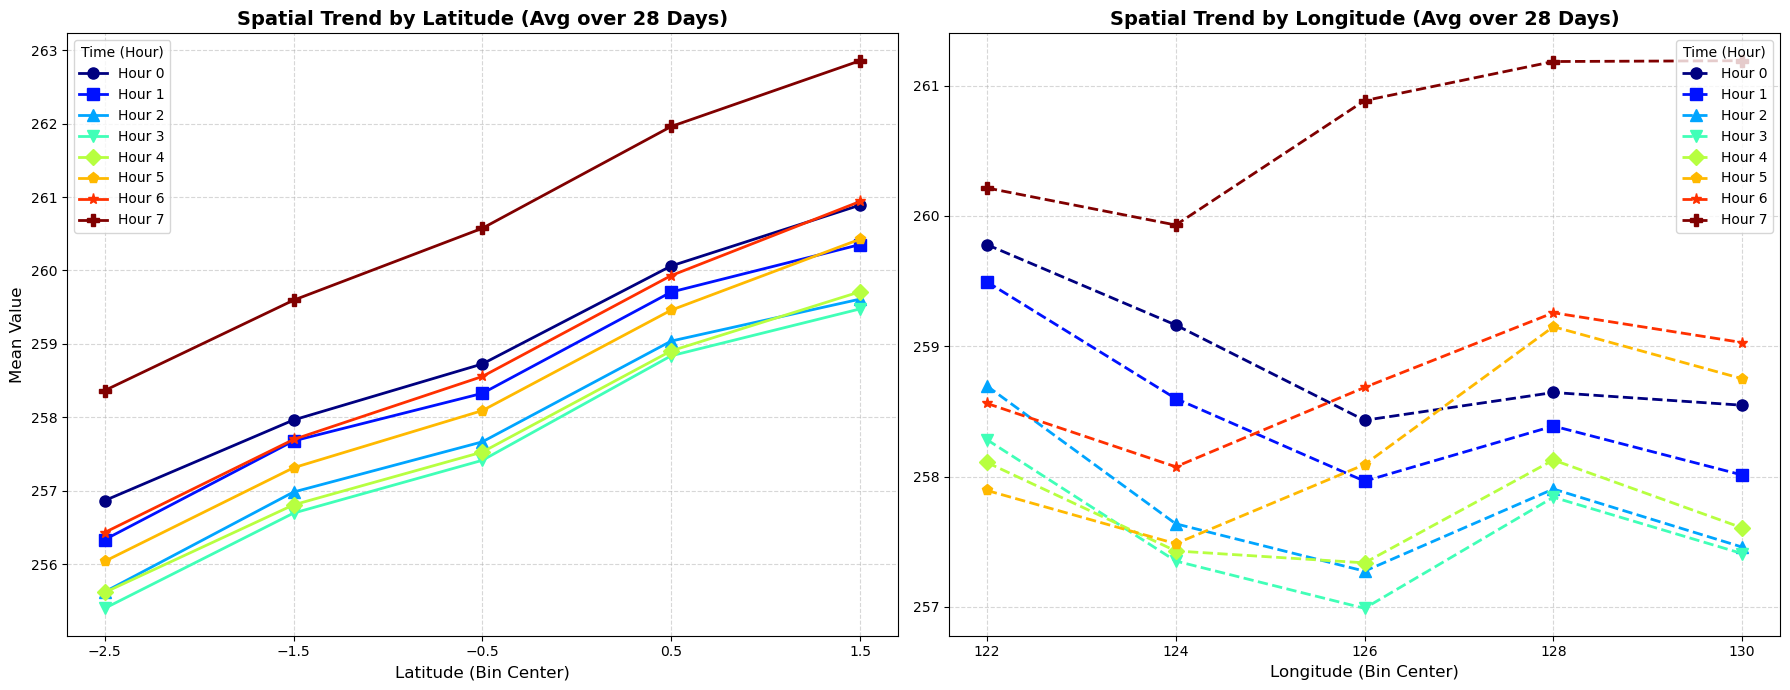

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def analyze_average_trend_28days_spatial_x(data_maps, days_to_average=28):
    """
    첫 28일(Day 0 ~ Day 27)의 데이터를 취합하여 평균을 낸 뒤,
    X축을 위도/경도로 설정하여 '시간대별(0~7시) 공간 패턴'을 그립니다.
    """
    
    # 1. Slice 구간 정의
    lat_bins = np.array([-3, -2, -1, 0, 1, 2])
    lon_bins = np.array([121, 123, 125, 127, 129, 131])
    
    # 그래프 X축에 사용할 구간의 중심값 계산 (예: -3~-2 -> -2.5)
    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
    
    # 2. 데이터 저장소 생성 (3D Array) -> [Day, Slice, Hour]
    lat_daily_storage = np.full((days_to_average, 5, 8), np.nan)
    lon_daily_storage = np.full((days_to_average, 5, 8), np.nan)

    print(f"--- Processing Average Trend for first {days_to_average} days ---")

    # --- [Loop] 28일 데이터 순회 ---
    for day_idx in range(days_to_average):
        if day_idx >= len(data_maps) or data_maps[day_idx] is None:
            continue
            
        day_data = data_maps[day_idx]
        
        # 키 정렬
        try:
            sorted_keys = sorted(day_data.keys(), key=lambda x: int(x) if isinstance(x, (int, str)) and str(x).isdigit() else x)
        except:
            sorted_keys = sorted(day_data.keys())
            
        for h_idx, key in enumerate(sorted_keys):
            if h_idx >= 8: break 
            
            tensor = day_data[key]
            if isinstance(tensor, torch.Tensor):
                data = tensor.detach().cpu().numpy()
            else:
                data = tensor
            
            if data.size == 0: continue

            lats = data[:, 0]
            lons = data[:, 1]
            vals = data[:, 2]
            
            # --- Latitude Slicing ---
            lat_inds = np.digitize(lats, lat_bins) - 1
            for i in range(5):
                mask = lat_inds == i
                if np.any(mask):
                    lat_daily_storage[day_idx, i, h_idx] = np.mean(vals[mask])
            
            # --- Longitude Slicing ---
            lon_inds = np.digitize(lons, lon_bins) - 1
            for i in range(5):
                mask = lon_inds == i
                if np.any(mask):
                    lon_daily_storage[day_idx, i, h_idx] = np.mean(vals[mask])

    # 3. 28일치 평균 계산 (Aggregation)
    # 결과 shape: (Slice=5, Hour=8)
    final_lat_means = np.nanmean(lat_daily_storage, axis=0)
    final_lon_means = np.nanmean(lon_daily_storage, axis=0)

    # 4. 그래프 그리기 (1행 2열)
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # 시간대별(0~7) 마커와 색상 정의
    # 마커 종류: 원, 네모, 세모, 역세모, 다이아몬드, 육각형, 별, 플러스
    markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'P'] 
    # 색상맵 (시간 흐름에 따라 그라데이션)
    colors = plt.cm.jet(np.linspace(0, 1, 8)) 

    # --- Latitude Plot (X축: Latitude) ---
    ax_lat = axes[0]
    for h in range(8): # 시간(Hour) 루프
        # 해당 시간의 모든 위도 구간 값 추출
        y_values = final_lat_means[:, h]
        
        # NaN이 아닌 경우만 플롯
        if not np.all(np.isnan(y_values)):
            ax_lat.plot(lat_centers, y_values, 
                        marker=markers[h], markersize=8, 
                        color=colors[h], linewidth=2, 
                        label=f'Hour {h}')
            
    ax_lat.set_title(f"Spatial Trend by Latitude (Avg over {days_to_average} Days)", fontsize=14, fontweight='bold')
    ax_lat.set_xlabel("Latitude (Bin Center)", fontsize=12)
    ax_lat.set_ylabel("Mean Value", fontsize=12)
    ax_lat.set_xticks(lat_centers) # X축 눈금을 구간 중심으로 고정
    ax_lat.grid(True, linestyle='--', alpha=0.5)
    ax_lat.legend(title="Time (Hour)", fontsize='medium')

    # --- Longitude Plot (X축: Longitude) ---
    ax_lon = axes[1]
    for h in range(8): # 시간(Hour) 루프
        # 해당 시간의 모든 경도 구간 값 추출
        y_values = final_lon_means[:, h]
        
        if not np.all(np.isnan(y_values)):
            ax_lon.plot(lon_centers, y_values, 
                        marker=markers[h], markersize=8, 
                        color=colors[h], linewidth=2, linestyle='--',
                        label=f'Hour {h}')
            
    ax_lon.set_title(f"Spatial Trend by Longitude (Avg over {days_to_average} Days)", fontsize=14, fontweight='bold')
    ax_lon.set_xlabel("Longitude (Bin Center)", fontsize=12)
    ax_lon.set_xticks(lon_centers) # X축 눈금을 구간 중심으로 고정
    ax_lon.grid(True, linestyle='--', alpha=0.5)
    ax_lon.legend(title="Time (Hour)", fontsize='medium')

    plt.tight_layout()
    plt.show()

# 실행
analyze_average_trend_28days_spatial_x(daily_hourly_maps_dw, days_to_average=28)

--- Aggregating data for 28 days ---


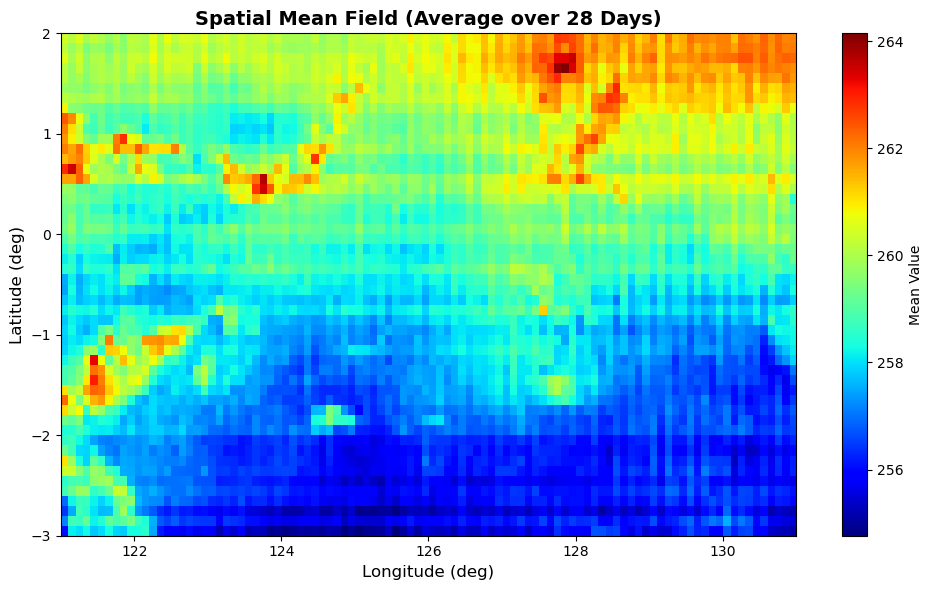

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import binned_statistic_2d

def plot_spatial_mean_field(data_maps, days_to_average=28, grid_size=0.1):
    """
    28일치 데이터를 모두 모아 (위도, 경도) 격자별로 평균을 낸 Heatmap을 그립니다.
    표준적인 지도 형태(X=Lon, Y=Lat)로 시각화합니다.
    """
    print(f"--- Aggregating data for {days_to_average} days ---")
    
    all_lats = []
    all_lons = []
    all_vals = []

    # 1. 28일치 데이터 수집 (모든 점을 리스트에 담기)
    for day_idx in range(days_to_average):
        if day_idx >= len(data_maps) or data_maps[day_idx] is None:
            continue
            
        day_data = data_maps[day_idx]
        for key in day_data.keys():
            tensor = day_data[key]
            if isinstance(tensor, torch.Tensor):
                data = tensor.detach().cpu().numpy()
            else:
                data = tensor
            
            if data.size == 0: continue
            
            # 데이터 누적
            all_lats.append(data[:, 0])
            all_lons.append(data[:, 1])
            all_vals.append(data[:, 2])

    # 리스트를 하나의 거대한 Numpy 배열로 병합
    if not all_vals:
        print("No data found.")
        return

    all_lats = np.concatenate(all_lats)
    all_lons = np.concatenate(all_lons)
    all_vals = np.concatenate(all_vals)

    # 2. 격자(Grid) 생성 및 평균 계산 (Binning)
    # 범위 설정
    lat_min, lat_max = -3, 2
    lon_min, lon_max = 121, 131
    
    # 격자 개수 계산
    lat_bins = np.arange(lat_min, lat_max + grid_size, grid_size)
    lon_bins = np.arange(lon_min, lon_max + grid_size, grid_size)
    
    # scipy를 이용해 2D Binning (격자 내 평균 계산)
    # 통상적인 지도(Map) 형태를 위해 x=lon, y=lat 순서로 넣습니다.
    # 만약 교수님 말씀대로 X=Lat, Y=Lon을 원하면 순서를 바꾸면 됩니다.
    ret = binned_statistic_2d(
        x=all_lons, 
        y=all_lats, 
        values=all_vals, 
        statistic='mean', 
        bins=[lon_bins, lat_bins]
    )
    
    heatmap_data = ret.statistic.T # Transpose to match (Y=Lat, X=Lon) convention for imshow

    # 3. 그리기
    plt.figure(figsize=(10, 6))
    
    # Heatmap 그리기
    # origin='lower': 아래쪽이 낮은 위도
    plt.imshow(heatmap_data, origin='lower', cmap='jet', aspect='auto',
               extent=[lon_min, lon_max, lat_min, lat_max])
    
    plt.colorbar(label='Mean Value')
    plt.title(f"Spatial Mean Field (Average over {days_to_average} Days)", fontsize=14, fontweight='bold')
    plt.xlabel("Longitude (deg)", fontsize=12)
    plt.ylabel("Latitude (deg)", fontsize=12)
    plt.grid(False) # Heatmap이라 그리드는 뺌 (필요하면 True)

    plt.tight_layout()
    plt.show()

# 실행
# grid_size=0.1은 약 10km 해상도입니다. 데이터 밀도에 따라 0.2나 0.5로 조절하세요.
plot_spatial_mean_field(daily_hourly_maps_dw, days_to_average=28, grid_size=0.1)

--- Aggregating Hourly Data for 28 days ---
Global Color Scale: 236.01 ~ 250.89


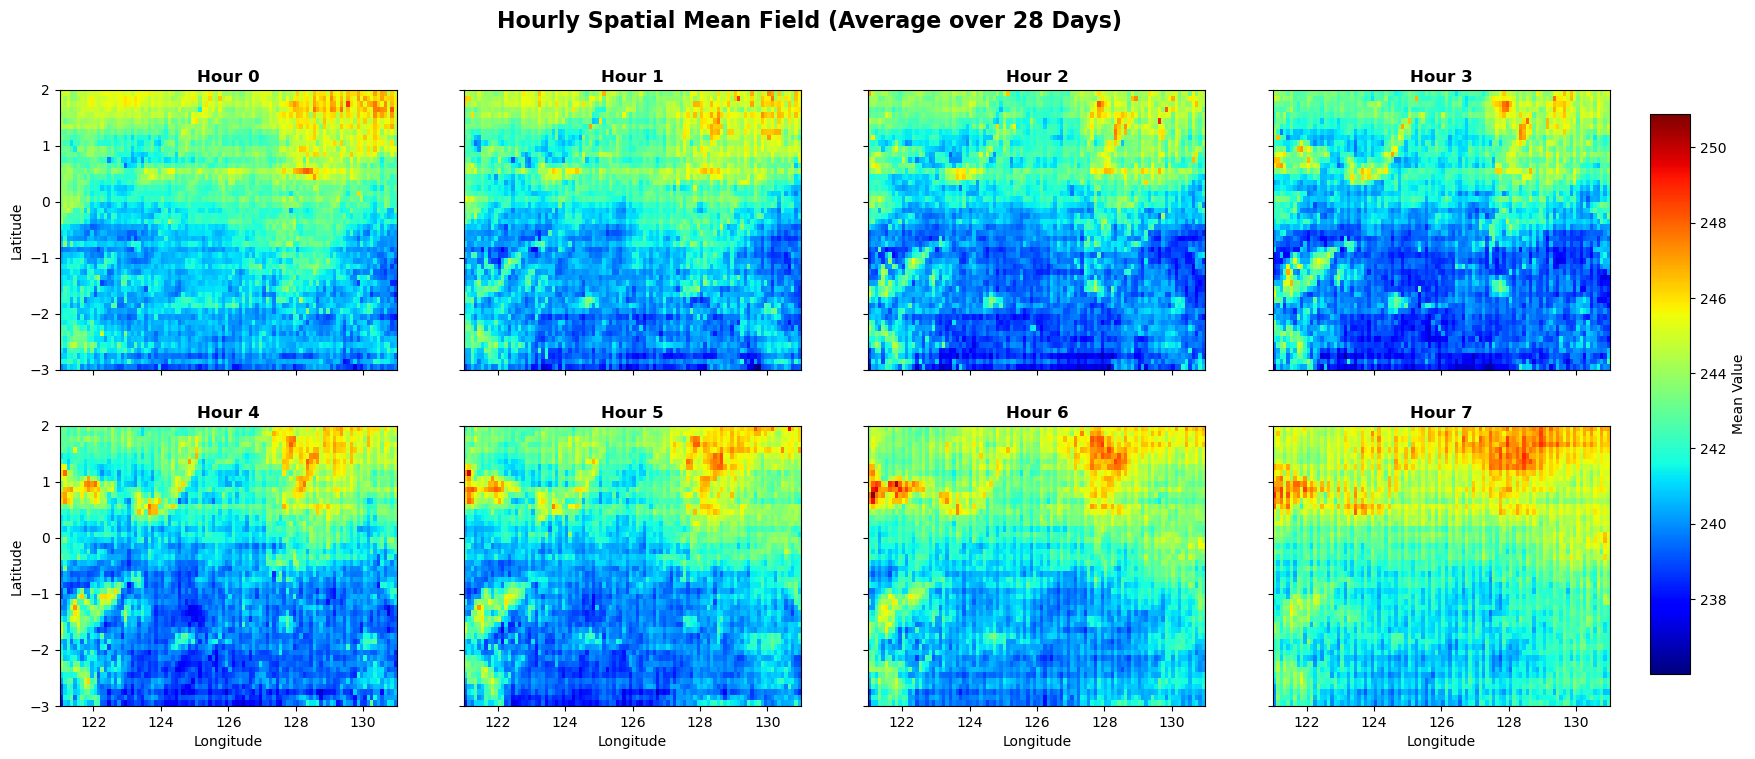

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import binned_statistic_2d

def plot_hourly_spatial_means(data_maps, days_to_average=28, grid_size=0.1):
    """
    28일치 데이터를 '시간대(Hour 0~7)'별로 모아서 공간 평균을 냅니다.
    2x4 Subplot으로 시각화하여 하루 동안의 변화 패턴(Diurnal Cycle)을 봅니다.
    """
    print(f"--- Aggregating Hourly Data for {days_to_average} days ---")
    
    # 1. 시간대별 데이터 저장소 (0~7시)
    # hourly_data[hour_idx] = {'lats': [], 'lons': [], 'vals': []}
    hourly_data = {h: {'lats': [], 'lons': [], 'vals': []} for h in range(8)}
    
    # 2. 데이터 수집
    for day_idx in range(days_to_average):
        if day_idx >= len(data_maps) or data_maps[day_idx] is None: continue
            
        day_data = data_maps[day_idx]
        
        # 키 정렬 (0, 1, ... 7)
        try:
            sorted_keys = sorted(day_data.keys(), key=lambda x: int(x) if str(x).isdigit() else x)
        except:
            sorted_keys = sorted(day_data.keys())
            
        for h_idx, key in enumerate(sorted_keys):
            if h_idx >= 8: break
            
            tensor = day_data[key]
            if isinstance(tensor, torch.Tensor):
                data = tensor.detach().cpu().numpy()
            else:
                data = tensor
            
            if data.size == 0: continue
            
            hourly_data[h_idx]['lats'].append(data[:, 0])
            hourly_data[h_idx]['lons'].append(data[:, 1])
            hourly_data[h_idx]['vals'].append(data[:, 2])

    # 3. 데이터 병합 및 격자화 (Gridding)
    # 모든 시간대의 데이터를 미리 계산해서 Global Min/Max를 찾습니다 (Colorbar 통일용)
    heatmaps = []
    
    # 범위 설정
    lat_min, lat_max = -3, 2
    lon_min, lon_max = 121, 131
    lat_bins = np.arange(lat_min, lat_max + grid_size, grid_size)
    lon_bins = np.arange(lon_min, lon_max + grid_size, grid_size)
    
    for h in range(8):
        if not hourly_data[h]['vals']:
            heatmaps.append(None)
            continue
            
        lats = np.concatenate(hourly_data[h]['lats'])
        lons = np.concatenate(hourly_data[h]['lons'])
        vals = np.concatenate(hourly_data[h]['vals'])
        
        ret = binned_statistic_2d(
            x=lons, y=lats, values=vals, 
            statistic='mean', bins=[lon_bins, lat_bins]
        )
        # Transpose for imshow (Y=Lat, X=Lon)
        heatmaps.append(ret.statistic.T)

    # 4. Global Min/Max 찾기 (Color Scale 통일)
    valid_maps = [m for m in heatmaps if m is not None]
    if not valid_maps:
        print("No data available.")
        return
        
    vmin = np.nanmin([np.nanmin(m) for m in valid_maps])
    vmax = np.nanmax([np.nanmax(m) for m in valid_maps])
    
    print(f"Global Color Scale: {vmin:.2f} ~ {vmax:.2f}")

    # 5. Plotting (2x4 Grid)
    fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for h in range(8):
        ax = axes[h]
        if heatmaps[h] is None:
            ax.text(0.5, 0.5, "No Data", ha='center', transform=ax.transAxes)
            continue
            
        im = ax.imshow(heatmaps[h], origin='lower', cmap='jet', aspect='auto',
                       extent=[lon_min, lon_max, lat_min, lat_max],
                       vmin=vmin, vmax=vmax) # [중요] 스케일 고정
        
        ax.set_title(f"Hour {h}", fontweight='bold')
        ax.grid(False)
        
        # 첫 번째 열에만 Y축 라벨, 마지막 행에만 X축 라벨
        if h % 4 == 0: ax.set_ylabel("Latitude")
        if h >= 4: ax.set_xlabel("Longitude")

    # 공통 Colorbar 추가
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax, label='Mean Value')
    
    fig.suptitle(f"Hourly Spatial Mean Field (Average over {days_to_average} Days)", fontsize=16, fontweight='bold')
    # plt.tight_layout(rect=[0, 0, 0.9, 1]) # Colorbar 공간 확보
    plt.show()

# 실행
plot_hourly_spatial_means(daily_hourly_maps_dw, days_to_average=28, grid_size=0.1)
